In [1]:
from torchvision import datasets, transforms
import torch
from torch import nn
from torch import functional as F
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from opacus import PrivacyEngine
from torchvision import datasets, transforms
import os
import syft as sy
from collections import OrderedDict

In [2]:
train_dataset = datasets.MNIST(root=".", train=True, download=True)

In [3]:
mnist_mean = 0.1307
mnist_std = 0.3081
batch_size = 64
epochs = 10
lr = 0.1
sigma = 1.0
max_per_sample_grad_norm = 1.0
delta = 1e-5
root = "."
weights_filename = "mnist_cnn_weights.pt"
device = torch.device("cpu")

train_loader = torch.utils.data.DataLoader(
    datasets.MNIST(
        root,
        train=True,
        download=True,
        transform=transforms.Compose(
            [
                transforms.ToTensor(),
                transforms.Normalize((mnist_mean,), (mnist_std,)),
            ]
        ),
    ),
    batch_size=batch_size,
    shuffle=True,
    num_workers = 1,
    pin_memory = True
)

class Model(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(1, 16, 8, 2, padding=3)
        self.conv2 = nn.Conv2d(16, 32, 4, 2)
        self.fc1 = nn.Linear(32 * 4 * 4, 32)
        self.fc2 = nn.Linear(32, 10)

    def forward(self, x):
        x = F.relu(self.conv1(x))  # -> [B, 16, 14, 14]
        x = F.max_pool2d(x, 2, 1)  # -> [B, 16, 13, 13]
        x = F.relu(self.conv2(x))  # -> [B, 32, 5, 5]
        x = F.max_pool2d(x, 2, 1)  # -> [B, 32, 4, 4]
        x = x.view(-1, 32 * 4 * 4)  # -> [B, 512]
        x = F.relu(self.fc1(x))  # -> [B, 32]
        x = self.fc2(x)  # -> [B, 10]
        return x

In [4]:
def train(model, device, train_loader, optimizer, epoch):
    model.train()
    criterion = nn.CrossEntropyLoss()
    losses = []
    for _batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)
        
        optimizer.zero_grad()
        
        output = model(data)
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()
        losses.append(loss.item())

        epsilon, best_alpha = optimizer.privacy_engine.get_privacy_spent(delta)
        print(
            f"Train Epoch: {epoch} \t"
            f"Loss: {np.mean(losses):.6f} "
            f"(ε = {epsilon:.2f}, δ = {delta}) for α = {best_alpha}"
        )

def train_model():  
    model = Model().to(device)
    optimizer = optim.SGD(model.parameters(), lr=lr, momentum=0)

    privacy_engine = PrivacyEngine(
        model,
        batch_size=batch_size,
        sample_size=len(train_loader.dataset),
        alphas=[1 + x / 10.0 for x in range(1, 100)] + list(range(12, 64)),
        noise_multiplier=sigma,
        max_grad_norm=max_per_sample_grad_norm,
    )

    privacy_engine.attach(optimizer)

    for epoch in range(1, epochs + 1):
        train(model, device, train_loader, optimizer, epoch)
    
    torch.save(model.state_dict(), weights_filename)
    return model

In [5]:
if os.path.isfile(root + "/" + weights_filename):
    model = Model()
    model.load_state_dict(torch.load(weights_filename))
    model.eval()
else:
    model = train_model()
    model.eval()

In [6]:
conv_base_params = ["conv1.weight", "conv1.bias", "conv2.weight", "conv2.bias"]
fc_head_params = ["fc1.weight", "fc1.bias", "fc2.weight", "fc2.bias"]
state_dict = model.state_dict()
conv_base_weights = OrderedDict()
fully_connected_weights = OrderedDict()

for param_name in conv_base_params:
    conv_base_weights[param_name] = state_dict[param_name]

for param_name in fc_head_params:
    fully_connected_weights[param_name] = state_dict[param_name]

In [7]:
class ConvolutionalBase(sy.Module):
    def __init__(self, torch_ref):
        super().__init__(torch_ref=torch_ref)
        self.conv1 = self.torch_ref.nn.Conv2d(1, 16, 8, 2, padding=3)
        self.conv2 = self.torch_ref.nn.Conv2d(16, 32, 4, 2)
        
    def forward(self, x):
        x = self.torch_ref.nn.functional.relu(self.conv1(x))
        x = self.torch_ref.nn.functional.max_pool2d(x, 2, 1)
        x = self.torch_ref.nn.functional.relu(self.conv2(x))
        x = self.torch_ref.nn.functional.max_pool2d(x, 2, 1)
        x = x.view(-1, 32 * 4 * 4)
        return x

class FullyConnectedHead(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(32 * 4 * 4, 32)
        self.fc2 = nn.Linear(32, 10)

    
    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

conv_base = ConvolutionalBase(torch)
conv_base.load_state_dict(conv_base_weights)

fully_connected_head = FullyConnectedHead()
fully_connected_head.load_state_dict(fully_connected_weights)

<All keys matched successfully>

In [8]:
for train_batch_data, train_batch_label in train_loader:
    convolutional_representation = conv_base(train_batch_data)
    output = fully_connected_head(convolutional_representation)
    break

/home/tudor/anaconda3/envs/om_work/lib/python3.7/site-packages/torch/cuda/__init__.py:52: UserWarning: CUDA initialization: Found no NVIDIA driver on your system. Please check that you have an NVIDIA GPU and installed a driver from http://www.nvidia.com/Download/index.aspx (Triggered internally at  /pytorch/c10/cuda/CUDAFunctions.cpp:100.)
  return torch._C._cuda_getDeviceCount() > 0


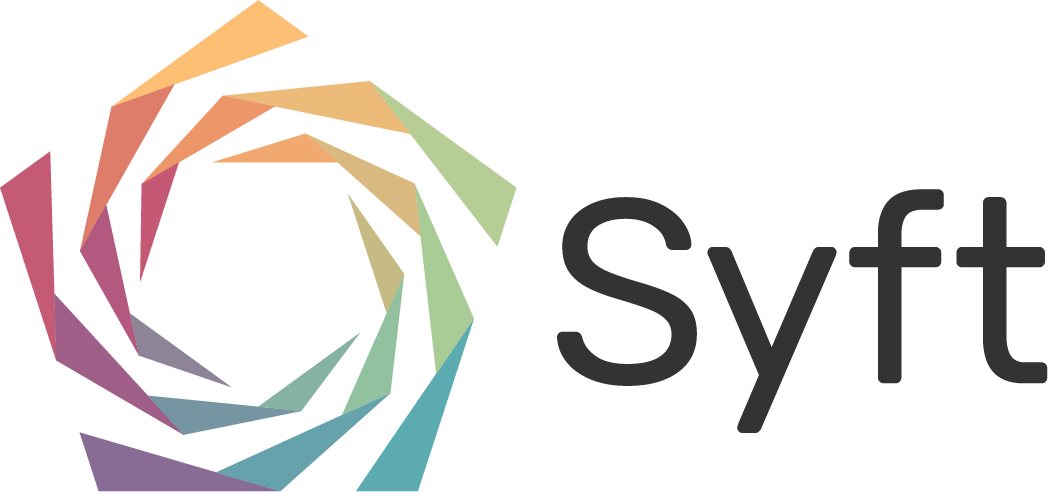

🎤  🎸  ♪♪♪ Joining Duet ♫♫♫  🎻  🎹

♫♫♫ > DISCLAIMER: Duet is an experimental feature currently in beta.
♫♫♫ > Use at your own risk.


    > ❤️ Love Duet? Please consider supporting our community!
    > https://github.com/sponsors/OpenMined

♫♫♫ > Punching through firewall to OpenGrid Network Node at:
♫♫♫ > http://ec2-18-216-8-163.us-east-2.compute.amazonaws.com:5000
♫♫♫ >
♫♫♫ > ...waiting for response from OpenGrid Network... 
♫♫♫ > DONE!

♫♫♫ > CONNECTED!


In [9]:
duet = sy.join_duet(loopback=True)

In [15]:
remote_private_data_ptr = duet.store[0]

In [21]:
remote_conv_base = conv_base.send(duet)

In [22]:
intermediary_signal = remote_conv_base(remote_private_data_ptr)

In [25]:
local_signal = intermediary_signal.get(
        request_block=True,
        timeout_secs=5,
    )
result = fully_connected_head(local_signal)

In [26]:
print(result)

tensor([[-1.2920e+01, -3.1403e+01,  1.3933e+01, -4.2512e+01,  2.4508e+01,
          1.0322e+01,  4.8958e+01, -4.8276e+01,  1.0308e+01, -3.1207e+01],
        [-3.3529e+00, -5.3067e+00, -4.6994e+01, -4.4538e+01,  5.7638e+01,
         -1.8354e+01,  3.4413e+01, -4.3856e+01,  4.7934e-01,  5.9228e+00],
        [-2.4776e+01,  9.5833e+00, -1.1648e+01, -1.0046e+01, -1.5417e+01,
         -1.4571e+01, -3.5263e+01,  2.4265e+01,  2.2936e+01,  1.3727e+01],
        [-2.0084e+01,  3.1598e+01, -1.3886e+00, -8.1292e+00,  1.8422e+00,
         -1.6809e+01, -3.3776e+00,  9.5377e+00, -9.6907e+00, -3.5713e+00],
        [-4.3904e+01,  4.4924e+01, -1.3231e+01, -6.2145e-01,  4.2422e+00,
         -1.9068e+01, -1.3398e+01, -1.4405e+00,  9.2333e+00, -5.4997e+00],
        [-8.7637e+00, -2.0369e+00,  8.5714e+00, -4.1412e+01,  3.5204e+01,
         -4.8486e+00,  5.0089e+01, -4.6888e+01, -7.9126e+00, -3.1674e+01],
        [-5.1585e+01,  5.1000e+01, -7.0170e+00,  1.4164e+00,  1.4939e+01,
         -2.8415e+01, -1.0538e+0